<a href="https://colab.research.google.com/github/darking09/57_blocks_music/blob/main/proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Verificación de la utilización de una red neuronal y una regresión lineal con aprendizaje supervizado
---

Autores:
* Fernando Torres

In [20]:
# Agruegue aquí las librerías que necesite
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GRU, Dense, Input, Dropout, Flatten, AveragePooling2D
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from dataclasses import dataclass
from datetime import datetime
from functools import partial
from tqdm import tqdm

# 0. Funciones y elementos globales

---



In [3]:
# Function to breakout the dataframe
def simpleBreakoutDataFrame(df, start = None, end = None):
  
  if start is None and end is None:
    return df[:]
  elif start is None : 
    return df[:end]
  elif end is None :
    return df[start:]

  return df[start:end]

# function to transform an array to tensor
def transformToTensor(arrayNp):
  return tf.constant(np.array(arrayNp, dtype=np.float32), dtype='float32')

# Function to make the window for time series
def extract_sequences(X, window_size):
  while True:
    for i in range(X.shape[0] - window_size):
      seq_x = X[i: i + window_size]
      yield seq_x

# GRU Focaster Class
class GruForcaster(Model):
    def __init__(self, n_recurrent, activation, *args, **kwargs):
        super(GruForcaster, self).__init__(*args, **kwargs)
        drop = 0.2
        self.recurrent_layer = GRU(
            n_recurrent, 
            activation=activation,
            )


        self.inter1 = Dense(128, activation="linear")
        self.inter2 = Dense(64, activation="linear")
        self.inter3 = Dense(128, activation="linear")
        self.output_layer = Dense(1, activation="linear")
    
    def call(self, inputs):
        intermediate = self.recurrent_layer(inputs)
        inter1 = self.inter1(intermediate)
        inter2 = self.inter2(inter1)
        inter3 = self.inter3(inter2)
        output = self.output_layer(inter3)
        return output

# Data params class definition
@dataclass
class DatasetParams:
    window_size: int
    batch_size: int
    buffer_size: int

dataset_params = DatasetParams(
    window_size = 8,
    batch_size = 64,
    buffer_size = 1000
)

# Funtion to draw a priority graphic
def priorityGraphics(prioritiesData):
  plt.figure(figsize=(10,3), dpi = 180)

  for i in range(len(prioritiesData)) :
    data, ls, label = prioritiesData[i]
    plt.plot(data, ls = ls, label = label)
  
  plt.xticks(rotation=90)
  plt.grid(color='black', linestyle='-', linewidth=0.3)
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## 1. Entendimiento del problema
---
Agruegue una explicación de el problema que trata a solucionar. Intente dar respuesta a las siguientes preguntas:

* De dónde vienen los datos?
* Qué tipo de datos tenemos?
* En qué formato están los datos?
* Cuál es el objetivo de este proyecto?
* Quienes se beneficiarían del producto?

## ¿De dónde vienen los datos?

Este conjunto de datos fue tomado de Kaggle, es conocido como [123 emergency calls in Bogotá](https://www.kaggle.com/datasets/diegorojasdiaz/123-emergency-calls-in-bogota), segun estos contienen todo el historial de llamadas del 123 por un año.

## ¿Qué tipo de datos tenemos?

Acá contenemos la información relacionada por nombre de localidades, prioridad, clasificación final fecha de inicio del desplazamiento.

## ¿En qué formato están los datos?

La mayoria de los datos son categoricos, excepto la fecha de dezplamiento que para se categorico necesitaria un proceso.

## ¿Cuál es el objetivo de este proyecto?

Este mismo modelo fue trabajado en primer diplomado para el modulo de machine learning usando una regresión lineal con MLPRegressor de Sklearn, la idea de esta aplicación es hacer una especie de comparación entre la implementación de una red neuronal con deep learning contra un modelo construido para machine learning.

## ¿Quienes se beneficiarían del producto?

En el proyecto anterior la idea era pedecir el comportamiento de la linea para poder tener la preparación de los equipos de emergencia tuviera algun tipo de holgura a la hora de enfrentar estas emergencias. 

## 2. Carga de datos
---

Implemente las funciones necesarias para cargar la información en dependencia de su procedencia (web, archivos planos, csv, bases de datos, entre otros).

In [5]:
# Datos originales para el proyecto

previously_corpus = pd.read_csv('clean_df_123.csv')
previously_corpus.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,FECHA_INICIO_DESPLAZAMIENTO_MOVIL,CODIGO_LOCALIDAD,LOCALIDAD,EDAD,GENERO,RED,TIPO_INCIDENTE,PRIORIDAD,CLASIFICACION_FINAL
0,2019-01-01 00:04:37,11,Suba,NaN,NaN,Norte,Lesiones personales,Alta,Cancelado
1,2019-01-01 00:07:41,3,Santa Fe,51.0,Femenino,Norte,Dolor torácico,Alta,Traslado
2,2019-01-01 00:07:46,10,Engativá,NaN,NaN,Norte,Inconsciente/paro cardiorrespiratorio,Alta,Falsa Alarma
3,2019-01-01 00:08:06,16,Puente Aranda,NaN,NaN,Sur,Accidente de tránsito con heridos/muertos,Alta,Cancelado
4,2019-01-01 00:10:26,15,Antonio Nariño,NaN,NaN,Norte,Inconsciente/paro cardiorrespiratorio,Alta,Cancelado


In [6]:
# Ingrese su código aquí
corpus = pd.read_csv('process_data.csv')
corpus.head()

,Unnamed: 0,FECHA_INICIO_DESPLAZAMIENTO_MOVIL,Total_calls,Alta_counts_less_1,Media_counts_lag_less_1,Baja_counts_less_1,Suba_counts,Santa_Fe_counts,Engativá_counts,Puente_Aranda_counts,...,La_Candelaria_counts,Sumapaz_counts,Alta_counts,Media_counts,Baja_counts,No_Clasificado_counts,DAY_OF_WEEK,IS_WEEKEND,IS_HOLIDAY,training
0,0,2019-01-01 00:00:00,494,0,0,0,57,10,38,29,...,1,0,413,74,7,0,[1 0 0 0 0 0 0],0,1,[1 0 0 0 0 0 0 0 1]
1,1,2019-01-02 00:00:00,411,413,74,7,46,17,30,15,...,2,0,334,69,7,1,[0 1 0 0 0 0 0],0,0,[0 1 0 0 0 0 0 0 0]
2,2,2019-01-03 00:00:00,380,334,69,7,37,7,42,29,...,1,0,302,70,6,2,[0 0 1 0 0 0 0],0,0,[0 0 1 0 0 0 0 0 0]
3,3,2019-01-04 00:00:00,432,302,70,6,51,13,34,25,...,6,0,329,95,8,0,[0 0 0 1 0 0 0],0,0,[0 0 0 1 0 0 0 0 0]
4,4,2019-01-05 00:00:00,442,329,95,8,49,16,40,24,...,2,0,339,94,8,1,[0 0 0 0 1 0 0],0,0,[0 0 0 0 1 0 0 0 0]


## 3. Preprocesamiento
---

Escriba una función que permita preprocesar los datos en dependencia del dominio de la aplicación:

* Información estructurada: outliers, z-scaling, min-max normalization, entre otros.
* Texto: tokenization, stopwords, expresiones regulares, stemming, unidecode, entre otros.
* Imágenes: data augmentation, resizing, ajuste de color, entre otros.
* Series de tiempo: outliers, suavizado, interpolación, entre otros.

In [43]:
# Ingrese su código aquí
def preprocess(data):
    calls_123_train = simpleBreakoutDataFrame(data, end=256)
    x_calls_123_train = calls_123_train.values[:,26]
    x_calls_123_train_tf = transformToTensor(x_calls_123_train)
    gen_training = extract_sequences(x_calls_123_train_tf, dataset_params.window_size)

    calls_123_testing = simpleBreakoutDataFrame(data, start=256)
    x_calls_123_testing = calls_123_testing.values[:,26]
    x_calls_123_testing_tf = transformToTensor(x_calls_123_testing)

    dataset_training = (
        tf.data.Dataset.from_generator(
            partial(extract_sequences, X=x_calls_123_train_tf, window_size=dataset_params.window_size),
            output_types=tf.float32,
            output_shapes=(dataset_params.window_size, )
        )
        .map(lambda seq: (tf.reshape(seq[:-1], (-1, 1)), seq[-1]))
        .batch(dataset_params.batch_size, drop_remainder=True)
    )

    return dataset_training, x_calls_123_testing_tf

In [44]:
training_data_generator, testing_data = preprocess(corpus)

In [45]:
testing_data

<tf.Tensor: shape=(15,), dtype=float32, numpy=
array([510., 440., 485., 490., 460., 448., 427., 506., 422., 454., 481.,
       443., 547., 469., 313.], dtype=float32)>

## 4. Modelamiento
---

Seleccione un modelo apropiado para el problema que desea solucionar (clasificación, regresión, agrupamiento, tópicos, entre otros) y entrenelo con las representaciones obtenidas en el paso anterior.


In [46]:
def training(data, batch_size = 1, window_size = 1):
    #Warm up
    model_previously = GruForcaster(64, activation="relu")
    model_previously.build((dataset_params.batch_size, dataset_params.window_size, 1))
    model_previously.compile(loss="mse", optimizer=Adam(learning_rate=1e-4), metrics=[CategoricalAccuracy()])
    model_previously.load_weights("trained_model.h5")

    model_previously.fit(data, steps_per_epoch=200, epochs=10)

    model_previously.save_weights("trained_model_warm.h5")

    model = GruForcaster(64, activation="relu")
    model.build((1, 1, 1))
    model.load_weights("trained_model_warm.h5")

    return model

In [47]:
model = training(training_data_generator)

Epoch 1/10
200/200 [==============================] - 8s 38ms/step - loss: 572.8369 - categorical_accuracy: 1.0000
Epoch 2/10
200/200 [==============================] - 7s 37ms/step - loss: 539.4772 - categorical_accuracy: 1.0000
Epoch 3/10
200/200 [==============================] - 7s 37ms/step - loss: 472.6300 - categorical_accuracy: 1.0000
Epoch 4/10
200/200 [==============================] - 7s 37ms/step - loss: 511.2321 - categorical_accuracy: 1.0000
Epoch 5/10
200/200 [==============================] - 7s 37ms/step - loss: 497.6466 - categorical_accuracy: 1.0000
Epoch 6/10
200/200 [==============================] - 8s 38ms/step - loss: 1100.7870 - categorical_accuracy: 1.0000
Epoch 7/10
200/200 [==============================] - 8s 40ms/step - loss: 483.3497 - categorical_accuracy: 1.0000
Epoch 8/10
200/200 [==============================] - 7s 37ms/step - loss: 490.7728 - categorical_accuracy: 1.0000
Epoch 9/10
200/200 [==============================] - 7s 37ms/step - loss: 486.

In [48]:
model.summary()

Model: "gru_forcaster_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 multiple                  12864     
                                                                 
 dense_36 (Dense)            multiple                  8320      
                                                                 
 dense_37 (Dense)            multiple                  8256      
                                                                 
 dense_38 (Dense)            multiple                  8320      
                                                                 
 dense_39 (Dense)            multiple                  129       
                                                                 
Total params: 37,889
Trainable params: 37,889
Non-trainable params: 0
_________________________________________________________________


## 6. Evaluacion
---

Evalúe el desempeño de su modelo con una métrica de desempeño apropiada al problema.


In [27]:
def evaluate(model, data):
    preds = []
    init_val = data[0]

    for i in tqdm(range(len(data))):
      model_input = np.array(init_val, dtype="float32").reshape((1, 1, 1))
      pred = float(model.predict(model_input))
      preds.append(pred)
      init_val = pred

    return preds

In [49]:
preds = evaluate(model, testing_data)

100%|██████████| 15/15 [00:00<00:00, 22.20it/s]


In [50]:

data_graphic = [
    (preds, None, 'Predicho Prioridad Alta'),
    (testing_data, "--", 'Real Prioridad Alta')
]

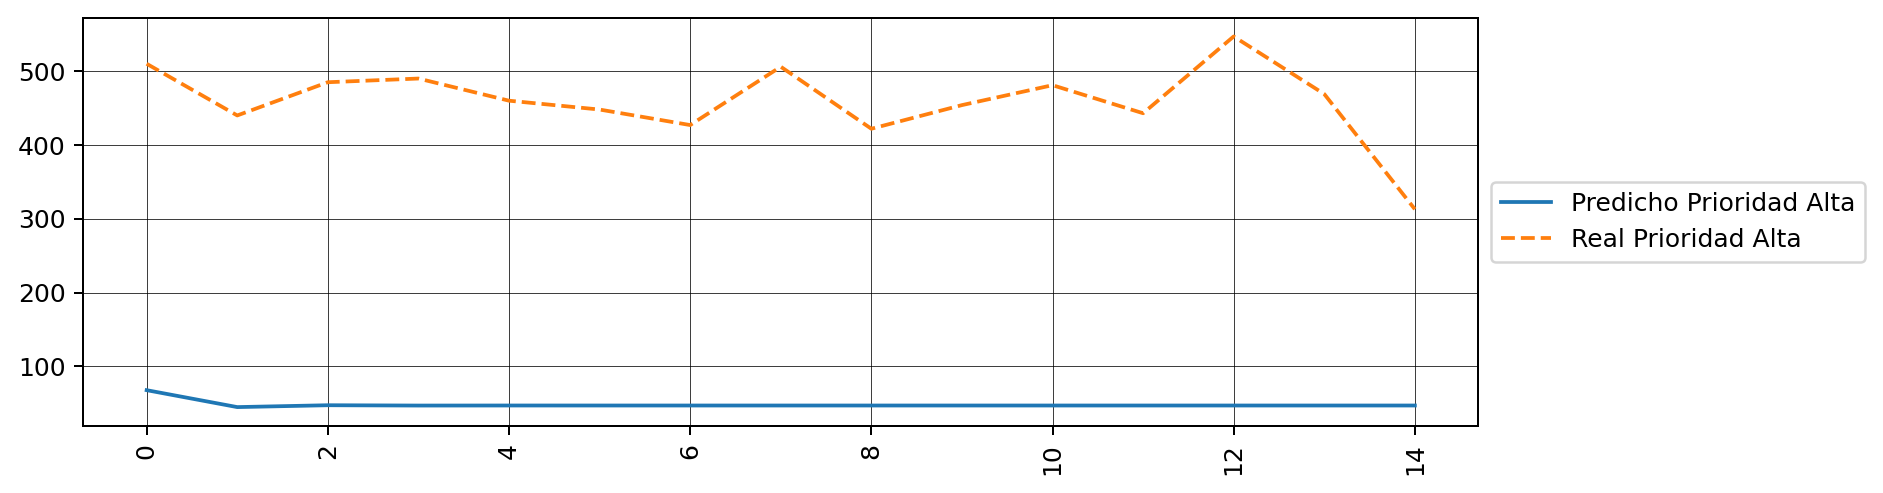

In [51]:
priorityGraphics(data_graphic)

## 7. Discusión y Conclusiones
---

El Como se puede observar el modelo no alcanza a realizar muy buenos resultados, esto se debe a la cantidad de datos y qeu falto un poco más de entrenamiento para ver si este podia aproximarse un poco más a la realidad de los datos, en si la enseñazan que nos deja esto en comparación con el modulo de machine learning es un aprendizaje más profundo de como manejar las series de tiempo de una manera más clara que lo aprendido anteriormente en el otro modulo, esto tal vez a la experiencia o a la practica que se esta adquiriendo con estos cursos.

Aunque en el modulo anterior los resultados fueron más precisos, esto demuestra que para esta cantidad de datos, se puede haber hecho con un regresion de sklearn.


## Nota
---
Se anexan un colab con el entrenamiento de este modelo, y el proyecto del modulo de machine learning.